In [1]:
import numpy as np 
import pandas as pd
import os
from tqdm import tqdm,tqdm_notebook
from scipy.signal import stft
import matplotlib.pyplot as plt

In [2]:
# 讀資料的部分需要另外調整路徑
X = pd.read_csv('train_features.csv').iloc[:-1,:] 
X1 = pd.read_csv('X.csv',index_col=['Unnamed: 0'])
X2 = pd.read_csv('X_1.csv',index_col=['Unnamed: 0'])
X3 = pd.read_csv('X_2.csv',index_col=['Unnamed: 0'])
y = pd.read_csv('y.csv',index_col=0,header=None)
X_t = pd.read_csv('test_features.csv').iloc[:,:]
X1_t = pd.read_csv('X_test.csv',index_col=['seg_id'])
X2_t = pd.read_csv('X_test _1.csv',index_col=['seg_id'])
X3_t = pd.read_csv('X_test_2.csv',index_col=['seg_id'])
X_t.index = X3_t.index
X_test = pd.concat([X_t,X1_t,X2_t,X3_t],axis=1)
X_train = pd.concat([X,X1,X2,X3],axis=1)

In [3]:
# X_t = pd.read_csv('test_features.csv').iloc[:,6:]
# X_t.index = X1_t.index
# X_test = pd.concat([X_t,X1_t,X2_t,X3_t],axis=1)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
import time
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [5]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [6]:
# 模型訊練，會生成交叉驗證結果跟提交結果，可以選擇是否畫出變數重要性
def train_model(X, X_test, y=y, params=None, folds=folds, plot_feature_importance=False):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n,(train_index,valid_index) in enumerate(folds.split(X)):
        
        print('Fold', fold_n, 'started at', time.ctime())

        
#         valid_index = np.arange(fold_n*l,(fold_n+1)*l)
#         train_index = np.delete(np.arange(4194),valid_index)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        

        model = lgb.LGBMRegressor(**params, n_estimators = 600000,verbose=10, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                verbose=50, early_stopping_rounds=200)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    feature_importance["importance"] /= n_fold
    if plot_feature_importance:
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:20].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');

        return oof, prediction, feature_importance
    return oof, prediction


Fold 0 started at Mon Mar  2 21:10:54 2020
Training until validation scores don't improve for 200 rounds
[50]	training's l1: 2.24969	valid_1's l1: 2.45595
[100]	training's l1: 1.92734	valid_1's l1: 2.20871
[150]	training's l1: 1.75469	valid_1's l1: 2.11995
[200]	training's l1: 1.6425	valid_1's l1: 2.08928
[250]	training's l1: 1.55202	valid_1's l1: 2.07602
[300]	training's l1: 1.47316	valid_1's l1: 2.07302
[350]	training's l1: 1.40342	valid_1's l1: 2.06648
[400]	training's l1: 1.33878	valid_1's l1: 2.0621
[450]	training's l1: 1.27808	valid_1's l1: 2.06249
[500]	training's l1: 1.22016	valid_1's l1: 2.06248
[550]	training's l1: 1.16597	valid_1's l1: 2.06076
[600]	training's l1: 1.11796	valid_1's l1: 2.06354
[650]	training's l1: 1.07105	valid_1's l1: 2.06428
[700]	training's l1: 1.02468	valid_1's l1: 2.06338
[750]	training's l1: 0.980752	valid_1's l1: 2.06483
Early stopping, best iteration is:
[550]	training's l1: 1.16597	valid_1's l1: 2.06076
Fold 1 started at Mon Mar  2 21:12:50 2020
Tra

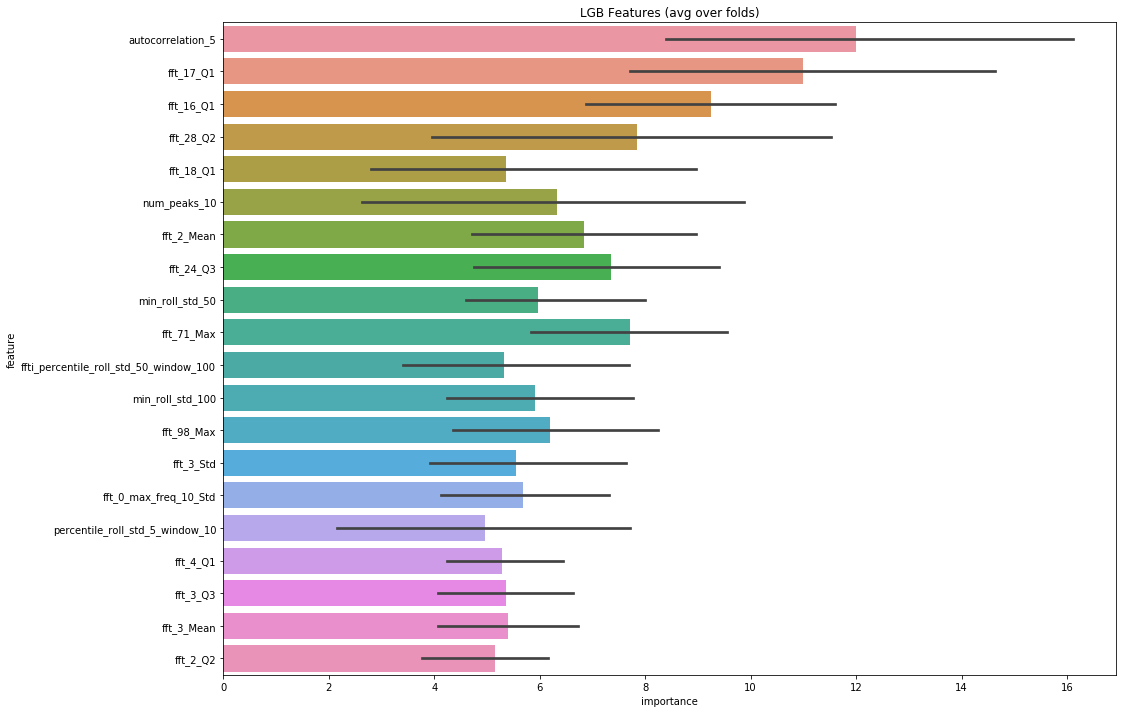

In [7]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'mae',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X=X_train, X_test=X_test,params=params, plot_feature_importance=True)

Fold 0 started at Mon Mar  2 21:30:02 2020
Training until validation scores don't improve for 200 rounds
[50]	training's l1: 2.36909	valid_1's l1: 2.52175
[100]	training's l1: 2.02359	valid_1's l1: 2.23733
[150]	training's l1: 1.84395	valid_1's l1: 2.13097
[200]	training's l1: 1.73243	valid_1's l1: 2.08893
[250]	training's l1: 1.6485	valid_1's l1: 2.06945
[300]	training's l1: 1.58143	valid_1's l1: 2.0575
[350]	training's l1: 1.5249	valid_1's l1: 2.04754
[400]	training's l1: 1.47729	valid_1's l1: 2.04415
[450]	training's l1: 1.43434	valid_1's l1: 2.03879
[500]	training's l1: 1.39591	valid_1's l1: 2.03541
[550]	training's l1: 1.36113	valid_1's l1: 2.03243
[600]	training's l1: 1.33205	valid_1's l1: 2.03123
[650]	training's l1: 1.30591	valid_1's l1: 2.03005
[700]	training's l1: 1.28217	valid_1's l1: 2.02818
[750]	training's l1: 1.2603	valid_1's l1: 2.02709
[800]	training's l1: 1.24104	valid_1's l1: 2.02687
[850]	training's l1: 1.22213	valid_1's l1: 2.02648
[900]	training's l1: 1.20578	vali

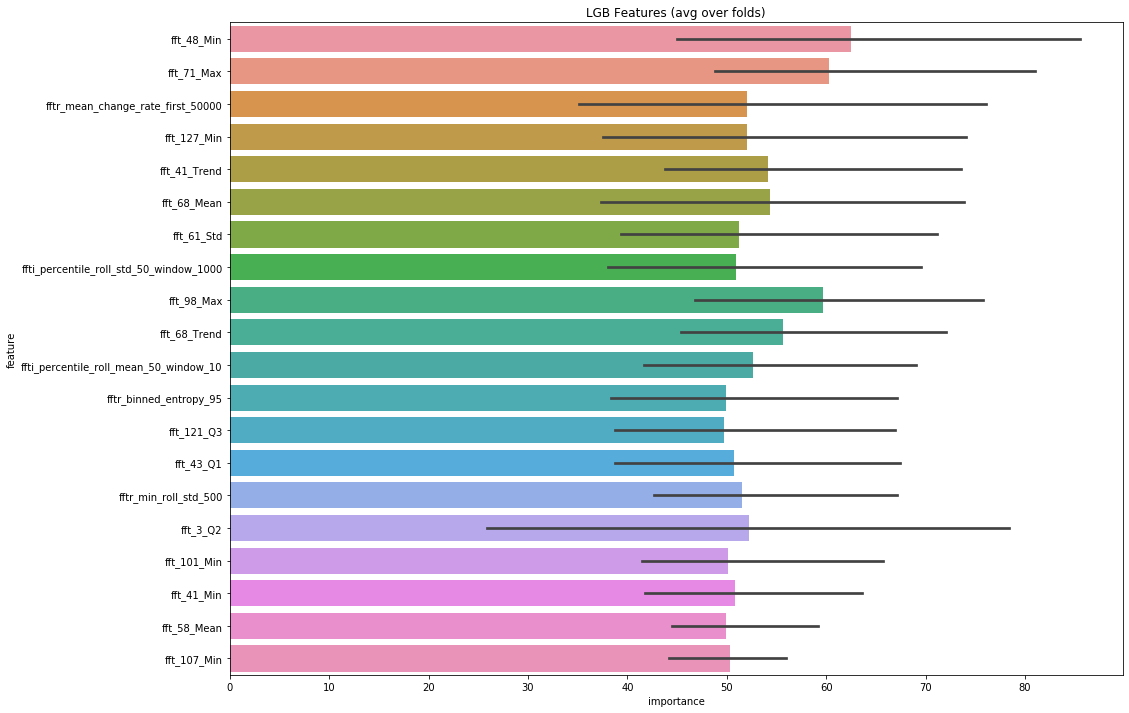

In [22]:
# 挑出重要性大於 3 個特徵，這裡可以自行更改。
select_col = list(set(feature_importance[feature_importance.importance>3].feature))
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'mae',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 1
         }
oof_lgb_r, prediction_lgb_r, feature_importance_r = train_model(X=X_train[select_col], X_test=X_test[select_col],params=params, plot_feature_importance=True)

In [1]:
sub = pd.read_csv('D:/LANL-Earthquake-Prediction/sample_submission.csv')
sub.time_to_failure = prediction_lgb_r
sub.set_index('seg_id').to_csv('gogogo2.csv',index_label='seg_id')